In [1]:
import torch
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
from datasets.custom_datasets import LSPDataset, MPIIDataset
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from models.pose_estimation_model import TransformerPoseModel
from utils.training_helpers import resize_single_joint
# from utils.training_helpers import plot_with_joints
from utils.training_helpers import plot_with_joints_r
from utils.preprocessing_helpers import get_image_sizes, get_list_of_image_names
from models.loss import JointsMSELoss
from torch.optim import Adam
from utils.heatmap_funcs import generate_gaussian_heatmap, generate_single_image_gaussian, upsample_heatmap
import torchvision.io
import datetime

In [2]:
mps_device = torch.device("mps")

In [3]:
# dataset loading
# annot = np.load('/home/mxerri/JointPoseEstimation/Data/lsp/leeds_sports_extended.npy')
annot = np.load('/Users/richardpignatiello/repos/4701/JointPoseEstimation/data/lsp/leeds_sports_extended.npy')
annot_s = np.swapaxes(annot, 0,2)
annot_s = np.swapaxes(annot_s,1,2)

# retrieve image sizes
# image_sizes = get_image_sizes('/home/mxerri/JointPoseEstimation/Data/lsp/images/')
image_sizes = get_image_sizes('/Users/richardpignatiello/repos/4701/JointPoseEstimation/data/lsp/images/')
# image_sizes_resized = get_image_sizes('/home/mxerri/JointPoseEstimation/Data/lsp/images224/')
image_sizes_resized = get_image_sizes('/Users/richardpignatiello/repos/4701/JointPoseEstimation/data/lsp/images224/')
annot_resize = np.zeros_like(annot_s)

# resize annotations
for i in range(10000):
    annot_resize[i] = resize_single_joint(annot_s[i],image_sizes_resized[i],image_sizes[i] ) 
    # make annortations into 56 x 56 for loss function 
    annot_resize[i] = resize_single_joint(annot_resize[i],(56,56),(224,224))

print(annot_resize.shape)

(10000, 14, 3)


(10, 14, 56, 56)
(56, 56)
(18, 40)
[18. 40.  1.]


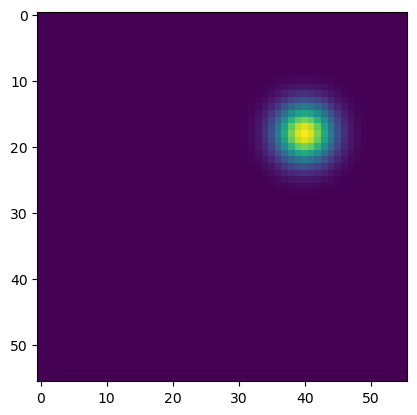

In [4]:
# convert to joint heatmaps from coordiantes: 
heatmaps = generate_gaussian_heatmap(annot_resize[0:10],(56,56),3)
print(heatmaps.shape)
# heatmaps_down = upsample_heatmap(heatmaps, (56,56))
plt.imshow(heatmaps[0][2])
print(heatmaps[0][2].shape)
z = np.unravel_index(heatmaps[0,2,:,:].argmax(), heatmaps[0,2,:,:].shape)
print(z)
print(annot_resize[0,2,:])

In [5]:
def test_plot():
  # im = torchvision.io.read_image('/Users/richardpignatiello/repos/4701/JointPoseEstimation/data/lsp/images224/resized_im00012.jpg')
  im = torchvision.io.read_image('/Users/richardpignatiello/Downloads/jpe_test/thomas.jpg')
  im = torch.unsqueeze(im, 0)
  im = im.to(mps_device)

  joints = model(im, False)
  # displayHeatmap(joints)
  joints = joints.squeeze()
  im = im.squeeze()
  x = []
  y = []
  for joint in joints:
    # print(f"max: {(joint==torch.max(joint)).nonzero()}")
    coor = (joint==torch.max(joint)).nonzero()
    print(torch.max(joint))
    if torch.max(joint) > .3:
      x.append(int(coor[0][0] * 4))
      y.append(int(coor[0][1] * 4))
      print((int(coor[0][0] * 4), int(coor[0][1] * 4)))
  im = im.cpu()
  plot_with_joints_r(im, x, y)

In [6]:
def displayHeatmap(heatmap):
  print('show image!!')
  for i in range(14):
    plt.imshow(heatmap[0][i].detach().cpu().numpy())
    plt.show()

In [7]:
def train(save_path):
    num_batches = len(train_loader)
    for epoch in range(200):
        start_epoch = datetime.datetime.now()
        total_loss = 0
        count = 0
        load_tensor_total = datetime.timedelta()
        model_computation_total = datetime.timedelta()
        calc_loss_total = datetime.timedelta()
        loss_backward_total = datetime.timedelta()
        optimizer_time_total = datetime.timedelta()
        for batch_idx, (imgs, labels, _) in enumerate(train_loader):
            load_tensors_start = datetime.datetime.now()
            imgs = imgs.to(mps_device)
            labels = labels.float()
            labels = labels.to(mps_device)
            load_tensor_total += datetime.datetime.now() - load_tensors_start

            optimizer.zero_grad()

            computation_start = datetime.datetime.now()
            output = model(imgs, 'train') # -> (5, H/4, W/4, #joints) 
            computation_time_total = datetime.datetime.now() - computation_start

            calc_loss_start = datetime.datetime.now()
            loss = loss_func(output, labels.float())
            calc_loss_total += datetime.datetime.now() - calc_loss_start
            
            loss_backward_start = datetime.datetime.now()
            loss.backward()
            loss_backward_total += datetime.datetime.now() - loss_backward_start

            optimizer_start_time = datetime.datetime.now()
            optimizer.step()
            optimizer_time_total = datetime.datetime.now() - optimizer_start_time
            total_loss += loss

            # print("batch completed")
            # if batch_idx % 31 == 0 and batch_idx > 0:
                # print(f"{int(batch_idx / len(train_loader) * 100) + 1}%")
                # print(f"{int(batch_idx / 625 * 100) + 1}%")
        if epoch % 1 == 0:
            print("epoch:", epoch, "loss: ", total_loss)
            elapsed_epoch = datetime.datetime.now() - start_epoch
            print(f"epoch {epoch} trained in: {elapsed_epoch}")
            print(f"AVG time per batch {elapsed_epoch / num_batches}")
            print(f"AVG tensor load time: {load_tensor_total / num_batches}")
            print(f"AVG prediction time: {computation_time_total / num_batches}")
            print(f"AVG loss calc time: {calc_loss_total / num_batches}")
            print(f"AVG loss backward time: {loss_backward_total / num_batches}")
            print(f"AVG optimizer step time: {optimizer_time_total / num_batches}")
            break
            # displayHeatmap(output)
            # test_plot()
        # if (epoch + 1) % 10 == 0:
            # torch.save(model.state_dict(), save_path)
            # displayHeatmap(output)
            # test_plot()

In [8]:
def validate():
  start_time = datetime.timedelta()
  total_loss = 0
  for batch_idx, (imgs, labels, _) in enumerate(test_loader):
    imgs = imgs.to(mps_device)
    labels = labels.float()
    labels = labels.to(mps_device)

    optimizer.zero_grad()

    output = model(imgs, 'val') # -> (5, H/4, W/4, #joints) 

    loss = loss_func(output, labels.float())
    
    loss.backward()

    total_loss += loss

  elapsed_time = datetime.datetime.now() - start_time

  print(f"finished validation in {elapsed_time}")
  print(f"loss: {total_loss}")
  print(f"loss x 4: {total_loss * 4}") # because validation data is 1/4 train data

In [9]:
# create officia datasets and dataloaders for training
image_name_list = get_list_of_image_names('/Users/richardpignatiello/repos/4701/JointPoseEstimation/data/lsp/images224/')
dataset = LSPDataset(annot_resize, image_name_list,"/Users/richardpignatiello/repos/4701/JointPoseEstimation/data/lsp/images224/",1)

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [8000, 2000])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False) # changed 32 -> 16
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # changed 32 -> 16

In [10]:
model = TransformerPoseModel(2)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = JointsMSELoss()
model.to(mps_device)

train('asdf')
validate()

/opt/miniconda3/envs/jpe/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


epoch: 0 loss:  tensor(1.2300, device='mps:0', grad_fn=<AddBackward0>)
epoch 0 trained in: 0:01:56.052478
AVG time per batch 0:00:00.464210
AVG tensor load time: 0:00:00.369159
AVG prediction time: 0:00:00.000050
AVG loss calc time: 0:00:00.006625
AVG loss backward time: 0:00:00.014356
AVG optimizer step time: 0:00:00.000095
finished validation in 2023-12-07 19:46:25.771386
loss: 0.12339607626199722
loss x 4: 0.4935843050479889


In [11]:
# # create officia datasets and dataloaders for training
# dataset = LSPDataset(annot_resize,"/Users/richardpignatiello/repos/4701/JointPoseEstimation/data/lsp/images224/", 3)
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [8000, 2000])
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False) # changed 32 -> 16
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False) # changed 32 -> 16

In [12]:
# model = TransformerPoseModel(2)
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# loss_func = JointsMSELoss()
# model.to(mps_device)

# train('trained_models/small_blur.pth')
# validate()

In [13]:
# model = TransformerPoseModel(2)
# model.load_state_dict(torch.load('/Users/richardpignatiello/repos/4701/JointPoseEstimation/trained_models/small_blur.pth'))
# mps_device = torch.device("mps")
# model.to(mps_device)

In [14]:
# vis_loader = DataLoader(test_dataset, 1, False)
# for batch_idx, (imgs, labels, path) in enumerate(vis_loader):
#   path = path[0]
#   if batch_idx == 50:
#     break
#   im = torchvision.io.read_image(path)
#   im = torch.unsqueeze(im, 0)
#   im = im.to(mps_device)

#   joints = model(im, 'pred')
#   joints = joints.squeeze()
#   im = im.squeeze()
#   x = []
#   y = []
#   for joint in joints:
#     # print(f"max: {(joint==torch.max(joint)).nonzero()}")
#     coor = (joint==torch.max(joint)).nonzero()
#     x.append(int(coor[0][0] * 4))
#     y.append(int(coor[0][1] * 4))
#   im = im.cpu()
#   plot_with_joints_r(im, x, y)
  
#   # print(x)
#   # print(y)

In [15]:
# for i in range(6):
#   im = torchvision.io.read_image(f'/Users/richardpignatiello/Downloads/jpe_test/IMG_847{i}.jpg')
#   im = torch.unsqueeze(im, 0)
#   im = im.to(mps_device)

#   joints = model(im, 'pred)
#   joints = joints.squeeze()
#   im = im.squeeze()
#   x = []
#   y = []
#   for joint in joints:
#     # print(f"max: {(joint==torch.max(joint)).nonzero()}")
#     coor = (joint==torch.max(joint)).nonzero()
#     x.append(int(coor[0][0] * 4))
#     y.append(int(coor[0][1] * 4))
#   im = im.cpu()
#   plot_with_joints_r(im, x, y)
#   # print(x)
#   # print(y)